In [1]:
import sys 
from pathlib import Path
import torch
import os
import dill
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
from pathlib import Path
import cv2
import time

sys.path.append("/home/franka_deoxys/diffusion_policy")
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.workspace.train_diffusion_unet_hybrid_workspace import TrainDiffusionUnetHybridWorkspace


sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")
from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger
from deoxys.experimental.motion_utils import follow_joint_traj, reset_joints_to


from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info


from util_eval import RobotStateRawObsDictGenerator, FrameStackForTrans

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

/home/franka_deoxys/miniconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/franka_deoxys/miniconda3/envs/robodiff/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
pybullet build time: Nov 28 2023 23:52:03


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type

spacemouse = SpaceMouse(vendor_id=9583, product_id=50734) 
#old spacemoue not wireless
# spacemouse = SpaceMouse(vendor_id=9583, product_id=50770)
spacemouse.start_control()
raw_obs_dict_generator = RobotStateRawObsDictGenerator()

[Deoxys Examples WARNING] This is a very dummy control policy!!!!! (Ln 1)


/tmp/ipykernel_99278/2074191932.py:1: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("This is a very dummy control policy!!!!!")


Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: SpaceMouse Wireless

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [4]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

### reset robot position (no need to do it from terminal)

In [7]:
# copied from reset_robot_joints.py
# Golden resetting joints
reset_joint_positions = [
    0.09162008114028396,
    -0.19826458111314524,
    -0.01990020486871322,
    -2.4732269941140346,
    -0.01307073642274261,
    2.30396583422025,
    0.8480939705504309,
]

In [8]:
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)

JOINT_POSITION


### getting lowdim obs + camera obs

In [13]:
camera_ids = [0, 1]
# camera_ids = [0]
cr_interfaces = {}

use_depth = False
for camera_id in camera_ids:
    camera_ref=f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print('---------****-----------')
    print(camera_info)
    print('--------------------------')
    # camera_info=  {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
# 

    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface

---------****-----------
{'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
---------****-----------
{'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False


In [14]:
def get_imgs(use_depth=False):
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"]=img_info

        imgs = cr_interfaces[camera_id].get_img()
    
        color_img = imgs["color"][..., ::-1]

        # color_img = cv2.resize(color_img, (128, 128))  
        # depth_img = cv2.resize(depth_img, (128, 128))

        # color_img = cv2.resize(color_img, (224, 224))  
        color_img = cv2.resize(color_img, None, fx=0.5, fy=0.5)

        data[f"camera_{camera_id}_color"]=color_img

        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (224, 224)) 
            data[f"camera_{camera_id}_depth"]=depth_img
    return data

In [15]:
data = get_imgs()
print('keys: ', data.keys())

img_wrist = data['camera_0_color']
img_front = data['camera_1_color']

agentview_rgb=img_wrist 
eye_in_hand_rgb=img_front
agentview_rgb.shape, eye_in_hand_rgb.shape

keys:  dict_keys(['camera_0', 'camera_0_color', 'camera_1', 'camera_1_color'])


((240, 320, 3), (240, 320, 3))

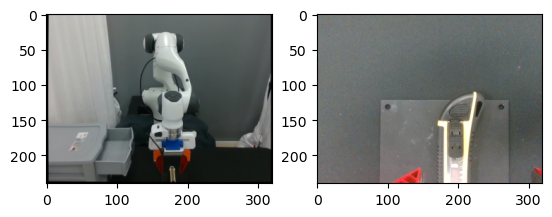

In [16]:
plt.subplot(121)
plt.imshow(agentview_rgb[:,:,::-1])
plt.subplot(122)
plt.imshow(eye_in_hand_rgb[:,:,::-1])

In [17]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]

    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})
    # obs_dict={} #rgb only 

    data = get_imgs()
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']

    agentview_rgb=img_wrist
    eye_in_hand_rgb=img_front
    # agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    # eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 

    # agentview_rgb.shape, eye_in_hand_rgb.shape

    obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

In [18]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
agentview_rgb (1, 3, 320, 240)
eye_in_hand_rgb (1, 3, 320, 240)


### Now load dp policy

In [19]:
# checkpoint = "/home/franka_deoxys/data_franka/dp_policy/after_train.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/after_train.ckpt"
checkpoint = "/media/franka_deoxys/DATA/trained_policies/drawer_lay53_after_train_313_epochs.ckpt"

payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg = payload['cfg'] 
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['gripper_states', 'joint_states', 'ee_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb', 'agentview_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/miniconda3/envs/robodiff/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/miniconda3/envs/robodiff/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 2.564722e+08
Vision params: 2.239418e+07


In [20]:
# get policy from workspace
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device(device)
policy.to(device)
policy.eval()
pass 

In [21]:
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action( action):
    raw_shape = action.shape
    if raw_shape[-1] == 20:
        # dual arm
        action = action.reshape(-1,2,10)

    d_rot = action.shape[-1] - 4
    pos = action[...,:3]
    rot = action[...,3:3+d_rot]
    gripper = action[...,[-1]]
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([
        pos, rot, gripper
    ], axis=-1)

    if raw_shape[-1] == 20:
        # dual arm
        uaction = uaction.reshape(*raw_shape[:-1], 14)

    return uaction


### test prediction on a obs

In [22]:
def predict_action(obs):
    """ 
    obs: 2x...
    """
    np_obs_dict = {key:obs[key] for key in keys_select}
    obs_dict = dict_apply(np_obs_dict, 
        lambda x: torch.from_numpy(x).to(
            device=device))

    for key in obs_dict.keys():
        obs_dict[key]=obs_dict[key].unsqueeze(0) 

    
    with torch.no_grad():
        action_dict = policy.predict_action(obs_dict)

    # device_transfer
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().to('cpu').numpy())


    # step env
    env_action =  np_action_dict['action']
    env_action = undo_transform_action(env_action)

    env_action=env_action.squeeze()
    return env_action

In [23]:
framestacker=FrameStackForTrans(2)
keys_select = ['agentview_rgb', 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

In [24]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys(): 
    print(key, obs_dict[key].shape)

ee_states (16,)
joint_states (7,)
gripper_states (1,)
agentview_rgb (3, 320, 240)
eye_in_hand_rgb (3, 320, 240)


In [25]:
framestacker=FrameStackForTrans(2) 
policy.reset()

obs_dict=get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)

In [26]:
obs_dict=get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)
action_pred=predict_action(obs)
action_pred

array([[-0.003, -0.006,  0.026, -0.002, -0.   ,  0.001,  0.998],
       [-0.002, -0.007,  0.025, -0.001, -0.001,  0.001,  0.998],
       [-0.   , -0.005,  0.025, -0.002, -0.   , -0.   ,  1.   ],
       [-0.001, -0.004,  0.024, -0.001,  0.001,  0.001,  0.999],
       [-0.003, -0.008,  0.022, -0.003,  0.001,  0.001,  0.999],
       [-0.003, -0.005,  0.023, -0.004, -0.003,  0.   ,  1.   ],
       [-0.003, -0.003,  0.024, -0.006,  0.   ,  0.001,  0.999],
       [-0.004, -0.004,  0.023, -0.006, -0.001,  0.001,  0.999]],
      dtype=float32)

### Now run inference in loop

In [29]:
# reset robot
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)

JOINT_POSITION


In [28]:
policy.reset()
 
images = []
for _ in range(500):
    action, grasp = input2action(
        device=spacemouse,
        controller_type=controller_type,
    )
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    obs_dict=get_current_obs(robot_interface)
    imgs1=obs_dict['agentview_rgb']
    imgs2=obs_dict['eye_in_hand_rgb']
    img=np.concatenate([imgs1, imgs2], axis=1).transpose(2,1,0)
    images.append(img)

    obs = framestacker.add_new_obs(obs_dict)
    action_pred=predict_action(obs)

    # print(f'actions: {action[0]:.3f} {action[1]:.3f} {action[2]:.3f} {action[-1]:.3f}')
    
    for action in action_pred:  
        robot_interface.control(
            controller_type=controller_type,
            action=action,
            controller_cfg=controller_cfg,
        )

    time.sleep(0.045)

    
robot_interface.close()

KeyboardInterrupt: 

### saving the images as video file

In [30]:
import imageio 
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d_%H_%M")
savepath = f"inference_videos/{now}.mp4"

print('saving video to: ', savepath)

writer = imageio.get_writer(savepath, fps=10)
for img in images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    writer.append_data(img)
writer.close()

saving video to:  inference_videos/2024-12-29_13_49.mp4
